In [1]:
import pandas as pd
import setuptools.dist
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
BASE_PATH = "/content/drive/MyDrive/"

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_PATH + "ApplePhotos",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2846 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Apple Black Rot', 'Apple Healthy', 'Apple Scab']

In [7]:
len(dataset)

89

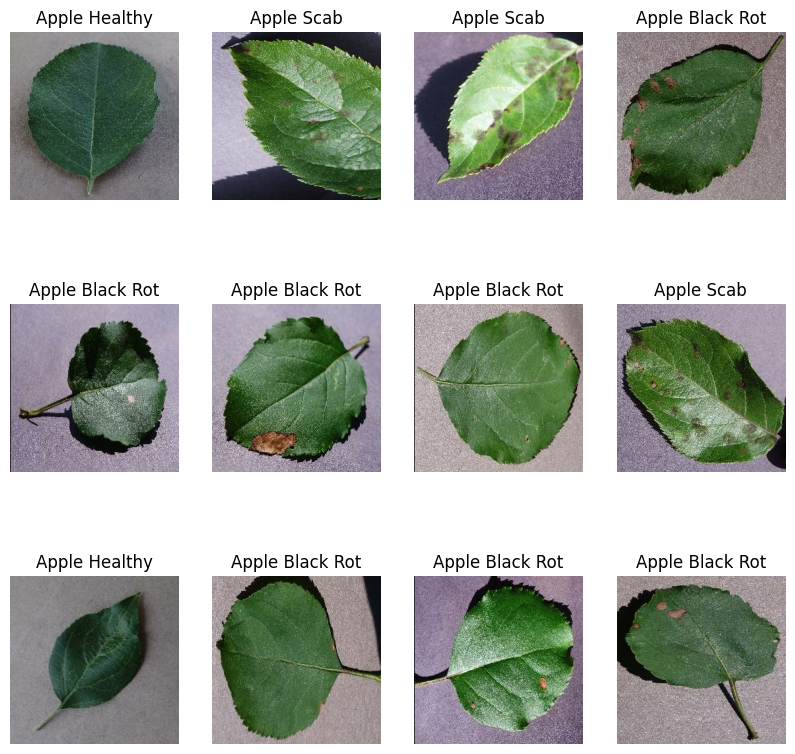

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

71.2

In [10]:
train_ds = dataset.take(143)
len(train_ds)

89

In [11]:
test_ds = dataset.skip(143)
len(test_ds)

0

In [12]:
val_size = 0.1
len(dataset)*val_size

8.9

In [13]:
val_ds = test_ds.take(17)
len(val_ds)

0

In [14]:
test_ds = test_ds.skip(17)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_slpit=0.1, shuffle=True, shuffle_size=1000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

71

In [18]:
len(val_ds)

8

In [19]:
len(test_ds)

10

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
#Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=false, name=Adam)
#default values, not necessary to mention
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
71/71 [==============================] - 381s 216ms/step - loss: 0.9653 - accuracy: 0.4696 - val_loss: 0.8575 - val_accuracy: 0.6367
Epoch 2/15
71/71 [==============================] - 4s 63ms/step - loss: 0.8329 - accuracy: 0.5621 - val_loss: 0.8144 - val_accuracy: 0.6133
Epoch 3/15
71/71 [==============================] - 4s 59ms/step - loss: 0.7639 - accuracy: 0.6062 - val_loss: 0.8493 - val_accuracy: 0.6211
Epoch 4/15
71/71 [==============================] - 4s 62ms/step - loss: 0.5452 - accuracy: 0.7454 - val_loss: 0.7524 - val_accuracy: 0.7930
Epoch 5/15
71/71 [==============================] - 4s 61ms/step - loss: 0.4040 - accuracy: 0.8379 - val_loss: 1.1216 - val_accuracy: 0.7305
Epoch 6/15
71/71 [==============================] - 4s 60ms/step - loss: 0.3118 - accuracy: 0.8789 - val_loss: 0.5280 - val_accuracy: 0.8828
Epoch 7/15
71/71 [==============================] - 4s 60ms/step - loss: 0.2184 - accuracy: 0.9141 - val_loss: 0.6148 - val_accuracy: 0.8203
Epoch 8/15

In [27]:
scores = model.evaluate(test_ds)


10/10 [==============================] - 10s 27ms/step - loss: 0.3418 - accuracy: 0.9031


In [28]:
scores

[0.34181565046310425, 0.903124988079071]

In [29]:
history

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Apple Black Rot
1/1 [==============================] - 0s 149ms/step
predicted label: Apple Black Rot


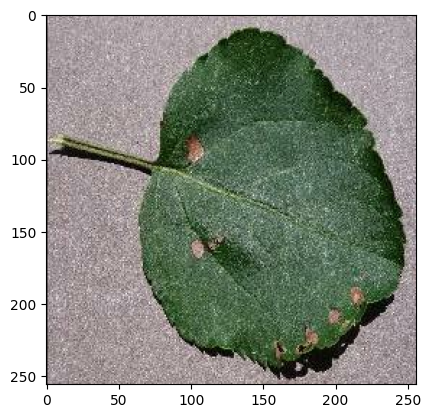

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


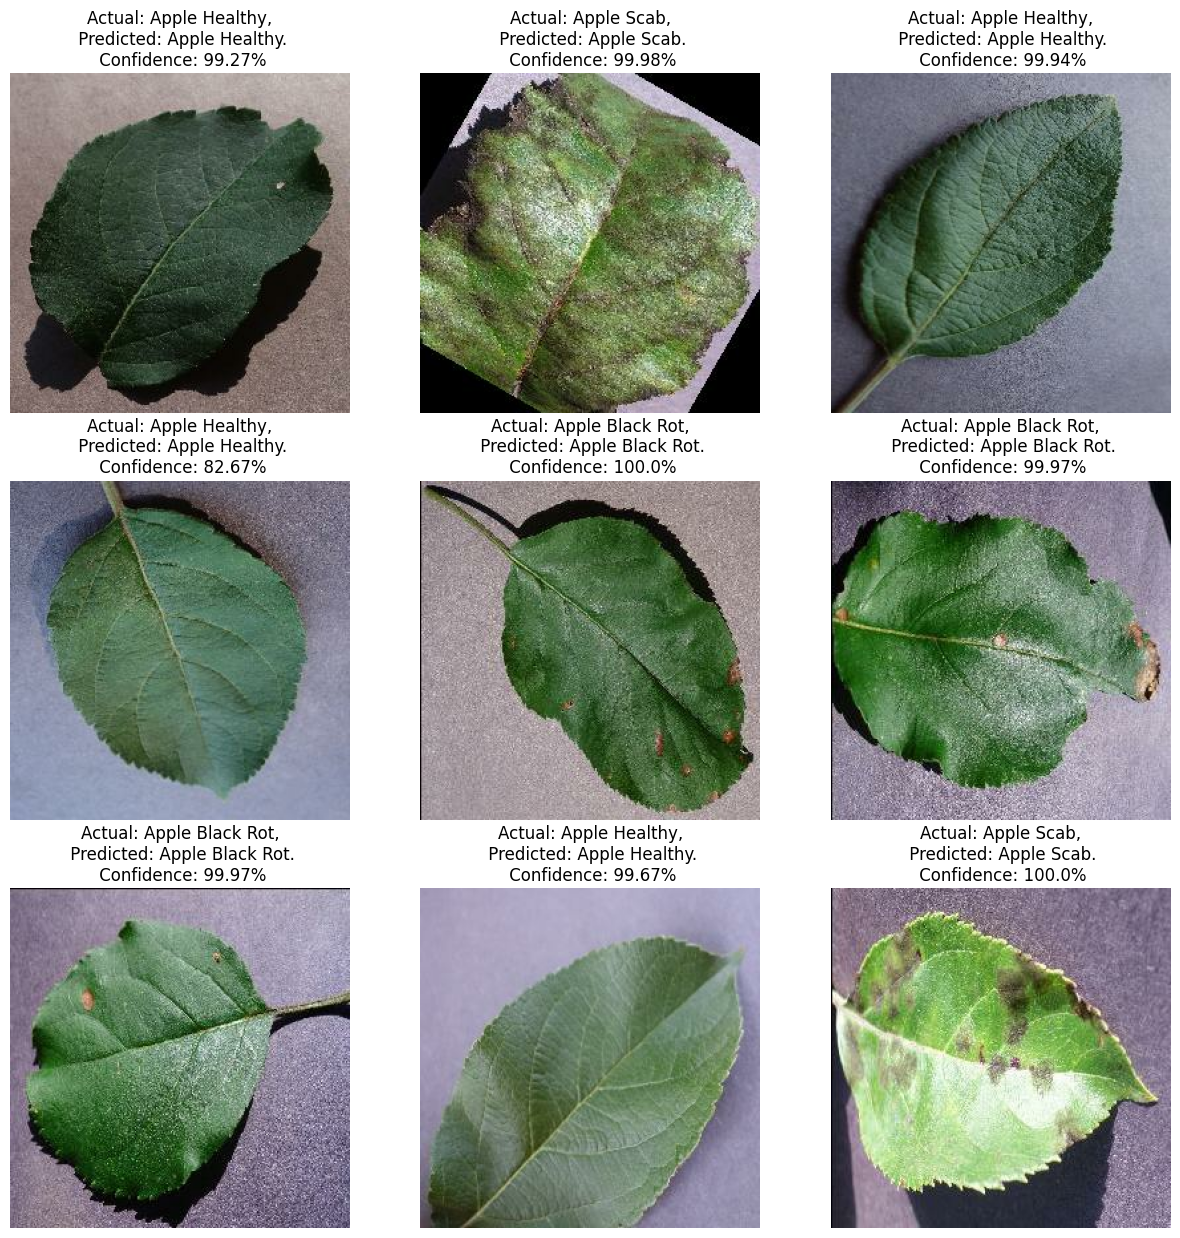

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [38]:
model.save("applemodel.h5")

In [39]:
import pickle

In [40]:
pickle.dump(model, open('/content/applepicklefile', 'wb'))